In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
%run ~/FKMC/notebooks/short_paper_figure_code/matplotlib_fig_settings.py

import multiprocessing as mp

np.seterr(under = 'ignore')
data_location = Path('~/HPC_data/pickled_data').expanduser()

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [12]:
import numpy as np
import scipy as scipy
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms

def solve_systems_no_binning(states, params):
    '''
    suggested usage:
    states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
    params = Munch(mu=0.0, beta = np.nan, U = U, t = t, N = N, alpha = 1.25, J = 1.0)
    energy_histogram_bins = np.linspace(-3*U, 3*U, 1000 + 1)
    
    #alternating = 2*(np.arange(N) % 2) - 1
    #alternating_power_law_noise = power_law_noise * alternating

    DOS, IPR, dDOS, dIPR = solve(states, params, energy_histogram_bins, scale = 10 / N)
    '''
    N = states.shape[-1]
    params.J_matrix = interaction_matrix(**params)

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    return Ff, Fc, eigenvals, raw_IPRs
  
def compute_IPR_and_DOS_histograms(raw_eigenvals, raw_IPRs, E_bins, bootstrap_bins = 1):
    '''
    Start with observations of states with energy raw_eigenvals[i,j] and inverse participation ratio raw_IPRs[i,j]
    They have shape M,N where M is the number of observed systems and N is the system size (hence number of states observed)
    i labels system conigurations and j labels individual states
    E_bins are the bins to sort into
    bootstrap_bins is how many bins to use to estimate the error when autocorrelation is present.

    #In the MCMC routine itself
    0) Calculate the IPRs from the eigenvectors, this looks like
       IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
       making sure to sum over the correct axis!

    #In this function
    1) transform from lists of energies and IPR observations to sum of:
        sum_DOS_ik: the number of observations of energy in each bin k at each sys config i
        sum_IPR_ik: the sum of IPRs for states in energy bin k at each sys config i
        
    2) estimate errors:
        DOS by simply binning
        IPR by estimating IPR = sum_IPR / sum_DOS at each sys config and binning
        
    3) take means of sum_DOS and sum_IPR

    4) calculate 
        IPR = <sum_IPR> / <sum_DOS>
        DOS = sum_DOS / energy_bin_width / system_size
    
    5) smooth out the spikieness of the resulting histogram using smooth
    
    Crucially the mean is taken before the ratio, doing it the other way doesn't seem to work.
    '''
    #take lists of IPR and eigenvalues and bin them into histograms
    sum_DOS, _, sorting_indices = index_histogram_array(E_bins, raw_eigenvals)
    sum_IPR = sort_IPRs(sorting_indices, raw_IPRs, E_bins)

    #the below method splits into bins to deal with autocorrelation, set N_bins = 1 to ignore autocorellation
    sum_dDOS = binned_error_estimate_multidim(sum_DOS, N_bins = bootstrap_bins, axis = 0)
    
    #NB you can't caculate the error in sum_IPR because that is highly correlated with how many states appear in a bin!!!
    _, non_meaned_IPR_ratios = normalise_IPR(sum_DOS, sum_IPR)
    dIPR = binned_error_estimate_multidim(non_meaned_IPR_ratios, N_bins = bootstrap_bins, axis = 0)
    
    #now take the means and then take the ratio again!
    sum_DOS = sum_DOS.mean(axis = 0)
    sum_IPR = sum_IPR.mean(axis = 0)
    
    #divide <IPR> by <DOS> without incurring divide by errors where DOS = 0, set IPR = 0 there too
    _, IPR = normalise_IPR(sum_DOS, sum_IPR)
    
    M, N = raw_eigenvals.shape
    bin_width = E_bins[1] - E_bins[0]
    a = bin_width * N
    DOS, dDOS = sum_DOS / a, sum_dDOS / a
    
    #shapes(DOS=DOS, dDOS=dDOS, IPR=IPR, dIPR=dIPR)
    return DOS, dDOS, IPR, dIPR
    
def process_raw_IPRs(o, eigenvals, raw_IPRs, energy_histogram_bins):
    o.DOS, o.dDOS, o.IPR, o.dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

def interpolate_IPR(E_bins, unsmoothed_DOS, IPR, dIPR):
    newshape = (IPR.size // IPR.shape[-1], IPR.shape[-1])
    _DOS = unsmoothed_DOS.reshape(newshape)
    _IPR = IPR.reshape(newshape)
    _dIPR = dIPR.reshape(newshape)
    
    for i, DOS, I, dI in zip(count(), _DOS, _IPR, _dIPR):
        ei = DOS > 0
        if any(ei):
            _I = I[ei]
            _dI = dI[ei]
            xI = E_bins[1:][ei]

            _IPR[i] = np.interp(E_bins[1:], xI, _I)
            _dIPR[i] = np.interp(E_bins[1:], xI, _dI)
        else:
            _IPR[i] = E_bins[1:] * np.NaN
            _dIPR[i] = E_bins[1:] * np.NaN

def smooth_IPR_and_DOS(o, scale):
    #smooth out the spikey IPR values
    o.DOS = smooth(o.DOS, scale = scale, axis = -1)
    o.IPR = smooth(o.IPR, scale = scale, axis = -1)
    
    o.dDOS = smooth(o.dDOS, scale = scale, axis = -1)
    o.dIPR = smooth(o.dIPR, scale = scale, axis = -1)

In [22]:
o = Munch(
    Ns = np.logspace(np.log10(70), np.log10(300), 10, dtype = int) // 10 * 10, #the system sizes to do
    M = int(1e4), #the number of replications to do, or maybe replications = M / system size, check the code
    p = 0.01, #the defect density
    hints = Munch(),
    parameters = Munch(
        alpha = 1.25,
        beta = np.NaN,
        U = 5,
        J = np.NaN,
        mu = 0,
        t = 1,
    )    
)

o.E_bins_number = [10,50,100,500,1000]
o.E_bin_array = [np.linspace(-6,6,n) for n in o.E_bins_number]

#msquared = data[1].Mf_moments[-1, :, 2].mean()
#o.p = np.sqrt(1 - msquared)
print(f'p = {o.p*100:.0f}') #the probability of a deviation from the CDW

os = [[Munch() for N in o.Ns] for N_bins in o.E_bins_number]

for name in "DOS IPR dDOS dIPR".split(): o.hints[name] = '[len(E_bins_number)] len(Ns) len(E_bins)'.split()

def solve_given_defect_densities_and_N(N, ps = 0.05):
    alternating_sign = 2*(np.arange(N) % 2) - 1
    flips = np.random.choice(a = [-1,1], size = (o.M // N, N), p = [o.p, 1-o.p])
    states = (alternating_sign * flips + 1) // 2
    
    o.parameters.N = N
    Ff, Fc, eigenvals, raw_IPRs = solve_systems_no_binning(states, o.parameters)
    
    return Munch(Ff=Ff, Fc=Fc, eigenvals=eigenvals, raw_IPRs=raw_IPRs)

t0 = time()
with mp.Pool(16) as pool:
    #d will have shape, (len(ps), 4, len(o.Ns), len(o.E_bins))
    raw_eigenvals_and_IPRs = pool.map(solve_given_defect_densities_and_N, o.Ns)
    
print(f'Done in {time() - t0:.0}s !')

p = 1
Done in 0.9s !


In [ ]:
t0 = time()
with mp.Pool(16) as pool:
    binned_data = [None for _ in o.E_bin_array]
    
    for i, E_bins in enumerate(o.E_bin_array):
        def process_raw(oraw, E_bins = E_bins):
            DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(oraw.raw_eigenvals, oraw.raw_IPRs, E_bins, bootstrap_bins = 1)
            return Munch(DOS=DOS, dDOS=dDOS, IPR=IPR, dIPR=dIPR)
    
        #d will have shape, (len(ps), 4, len(o.Ns), len(o.E_bins))
        binned_data[i] = pool.map(process_raw, raw_eigenvals_and_IPRs)
    
print(f'Done in {time() - t0:.0}s !')

Process ForkPoolWorker-177:
Process ForkPoolWorker-178:
Process ForkPoolWorker-179:
Process ForkPoolWorker-180:
Process ForkPoolWorker-181:
Process ForkPoolWorker-183:
Process ForkPoolWorker-182:
Process ForkPoolWorker-184:
Process ForkPoolWorker-185:
Traceback (most recent call last):
Process ForkPoolWorker-186:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tom/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tom/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tom/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tom/miniconda3/lib/python3.7/multiprocessing/process.p

In [ ]:


o = Munch(
    Ns = [10,], #the system sizes to do
    M = int(1e2), #the number of replications to do, or maybe replications = M / system size, check the code
    o.ps = [0.01, ], #the range of defect densities to use
    
    parameters = o.params = Munch(
        alpha = 1.25,
        beta = np.NaN,
        U = 5,
        J = np.NaN,
        mu = 0,
        t = 1,
    )    
)

o.E_bins_number = [10,50,100,500,1000]
o.E_bin_array = [np.linspace(-6,6,n) for n in o.E_bins_number]

#msquared = data[1].Mf_moments[-1, :, 2].mean()
#o.p = np.sqrt(1 - msquared)
print(f'p = {o.p*100:.0f}') #the probability of a deviation from the CDW

o.DOS, o.IPR, o.dDOS, o.dIPR = np.zeros(shape = (4, len(o.ps), len(o.Ns), len(o.E_bins)-1))
for name in "DOS IPR dDOS dIPR".split(): o.hints[name] = 'len(ps) len(Ns) len(E_bins)'.split()

def solve_given_defect_densities_and_N(ps, o = o):
    print(f'doing p = {p}')
    DOS, IPR, dDOS, dIPR = np.full(fill_value = np.NaN, shape = (4, len(o.Ns), len(o.E_bins)-1))
    for i,N in enumerate(o.Ns):
        alternating_sign = 2*(np.arange(N) % 2) - 1
        flips = np.random.choice(a = [-1,1], size = (o.M, N), p = [o.p, 1-o.p])

        o.parameters.N = N
        states = (alternating_sign * flips + 1) // 2

        DOS[i], IPR[i], dDOS[i], dIPR[i] = solve_systems(states, o.parameters, o.E_bins, scale = 10 / N)
    return DOS, IPR, dDOS, dIPR

with mp.Pool(16) as pool:
    ps = np.linspace(0,1,16)                               
    
    #d will have shape, (len(ps), 4, len(o.Ns), len(o.E_bins))
    d = pool.map(solve_given_defect_density, ps)
    o.DOS, o.IPR, o.dDOS, o.dIPR  = np.einsum('ijkl->jkil', d)
    
dirtyCDW = o  
print('Done')

In [12]:
import datetime
deathday = datetime.datetime(2071, 5, 23)
now = datetime.datetime.now()
seconds = (deathday - now).total_seconds()
days = seconds / (24*60*60)
print("{:,.0f}".format(days)) # change the number to change precision

18,473


In [10]:
50.57 * 365

18458.05

(array([4.+0.j, 0.+0.j, 2.-2.j, 0.+0.j, 0.+0.j]),
 array([ 4.+0.j,  0.+0.j, -2.+2.j,  0.+0.j,  0.+0.j]))

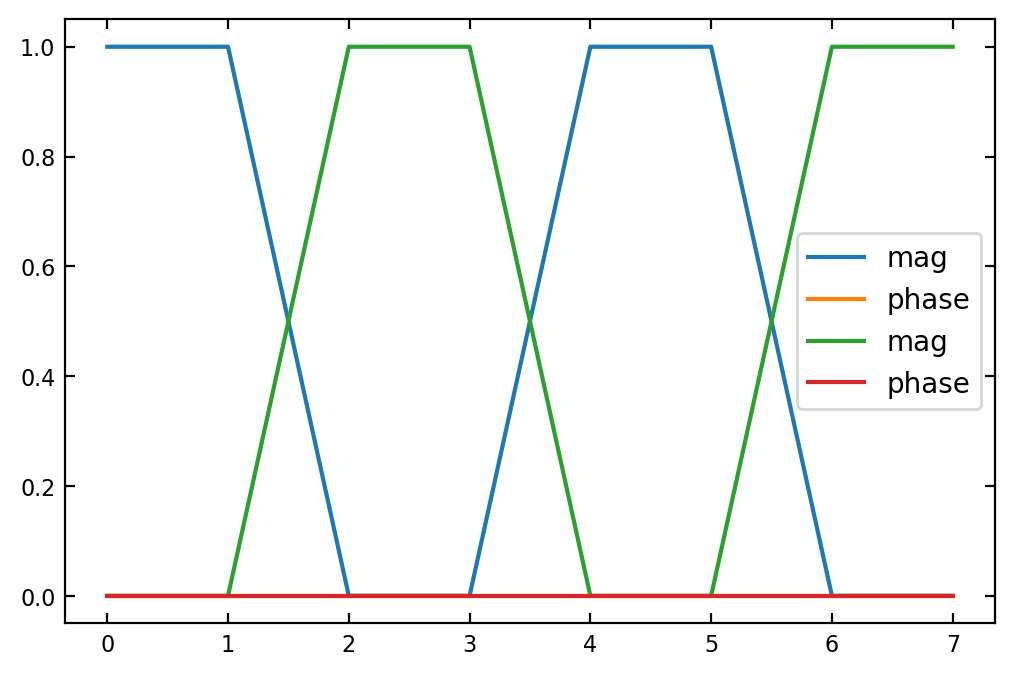

In [20]:
a = np.array([1,1,0,0,1,1,0,0])
b = np.roll(a, 6)
at = np.fft.rfft(a)
bt =  np.fft.rfft(b)

for f in [a,b]:
    plt.plot(np.real(f), label = 'mag')
    plt.plot(np.angle(f), label = 'phase')
plt.legend()

at, bt